In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-03-21 12:01:29.547089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-21 12:01:29.577751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-21 12:01:29.580172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-21 12:01:29.584038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Running on GPU


In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  float32
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  float32


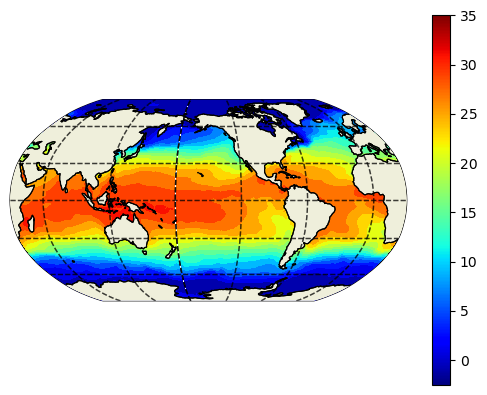

In [3]:
SST0 = ecco.llc_compact_to_tiles(ds_r5['SST'][0])

P = ecco.plot_proj_to_latlon_grid(ds_r4['XC'], ds_r4['YC'],
                                  np.asarray(SST0),
                                  plot_type = 'contourf',
                                  show_colorbar = True,
                                  cmap = 'jet', cmax = 35, user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [1,1,1])

In [4]:
# SST1000 = ecco.llc_compact_to_tiles(ds_r5['SST'][:1000])
# SST2000 = ecco.llc_compact_to_tiles(ds_r5['SST'][1000:2000])
# SST3000 = ecco.llc_compact_to_tiles(ds_r5['SST'][2000:3000])
# SST4000 = ecco.llc_compact_to_tiles(ds_r5['SST'][3000:4000])
# SST5000 = ecco.llc_compact_to_tiles(ds_r5['SST'][4000:5000])
# SST6000 = ecco.llc_compact_to_tiles(ds_r5['SST'][5000:6000])
# SST7000 = ecco.llc_compact_to_tiles(ds_r5['SST'][6000:7000])
# SST8000 = ecco.llc_compact_to_tiles(ds_r5['SST'][7000:8000])
# SST9000 = ecco.llc_compact_to_tiles(ds_r5['SST'][8000:9000])
# SST10000 = ecco.llc_compact_to_tiles(ds_r5['SST'][9000:10000])
# SST11000 = ecco.llc_compact_to_tiles(ds_r5['SST'][10000:11000])
# ### Pick data only till Dec 31, 2022 so 11323 instead of 11504
# SST11323 = ecco.llc_compact_to_tiles(ds_r5['SST'][11000:11323])

# SST = np.concatenate([SST1000 , SST2000 , SST3000,
#                       SST4000 , SST5000 , SST6000,
#                       SST7000 , SST8000 , SST9000,
#                       SST10000, SST11000, SST11323], 
#                       axis = 0)

# da_SST = xr.DataArray(SST)

# ds_SST = xr.Dataset()
# ds_SST = ds_SST.assign(SST = da_SST)
# ds_SST.to_netcdf(mainDir_r5+'/SST_all.nc')

In [5]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [6]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


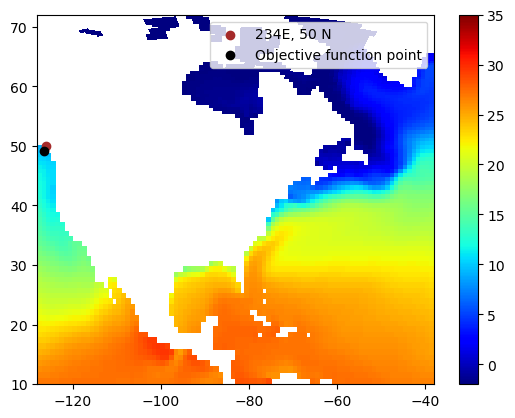

In [7]:
plt.pcolor(ds['XC'].isel(tile = 10), ds['YC'].isel(tile = 10), 
           ds['NaNmaskFinal'].isel(tile = 10)*ds['SST'].isel(time = 0, tile = 10), 
           cmap = 'jet', vmax = 35)
plt.colorbar()
plt.scatter(-126.0, 50.0, color = 'brown', label = '234E, 50 N')
plt.scatter(ds['XC'].isel(tile = 10, j = 1, i = 43),
            ds['YC'].isel(tile = 10, j = 1, i = 43),
            color = 'black', label = 'Objective function point')
plt.legend()

Text(0.5, 1.0, 'Mean MaskedSST 1992_01_01 to 2022_12_31')

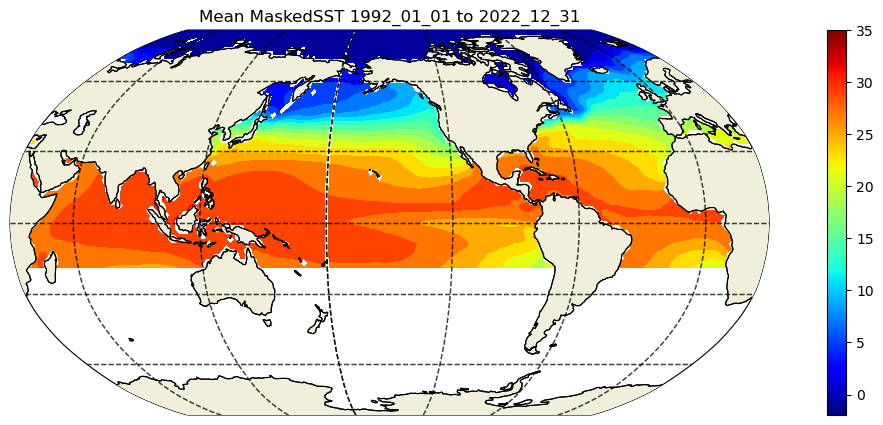

In [8]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['NaNmaskFinal']*ds['SST'].mean("time"),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True);
P[1].set_title("Mean MaskedSST 1992_01_01 to 2022_12_31")

In [9]:
def anomalize(field):
    
    leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8]
    leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8]

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            seasonal_trend[d] += field[d+365*year+leap_yr_offsets_jan_feb[year]]
    seasonal_trend[:59] = seasonal_trend[:59] / 31.0
    
    # Feb 29 starting 1996, so year 2 in 0-indefielding
    n = 0
    for year in range(0,31,4):
        seasonal_trend[59] += field[365*year+n+59]
        n = n+1
    seasonal_trend[59] = seasonal_trend[59] / 8.0
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            seasonal_trend[d] += field[d-1+365*year+leap_yr_offsets_after_feb[year]]
    seasonal_trend[60:] = seasonal_trend[60:] / 31.0
    
    #### Deseason data
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            field[d+365*year+leap_yr_offsets_jan_feb[year]] = field[d+365*year+leap_yr_offsets_jan_feb[year]] \
                                                        - seasonal_trend[d]
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    n = 0
    for year in range(0,31,4):
        field[365*year+n+59] = field[365*year+n+59] - seasonal_trend[59]
        n = n+1
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            field[d-1+365*year+leap_yr_offsets_after_feb[year]] = field[d-1+365*year+leap_yr_offsets_after_feb[year]] \
                                                            - seasonal_trend[d]

    scipy.signal.detrend(field, axis=0, type='linear', bp=0, overwrite_data=True)
    field = field - np.mean(field, axis = 0)

    return field

In [10]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [11]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

In [12]:
theta_anomaly = np.zeros((X_full.shape[0],ds['SST'].shape[1], ds['SST'].shape[2], ds['SST'].shape[3]), dtype = np.float64)
theta_anomaly[...] = np.nan
theta_anomaly[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X_full

Text(0.5, 1.0, 'Histogram of output data or QoI')

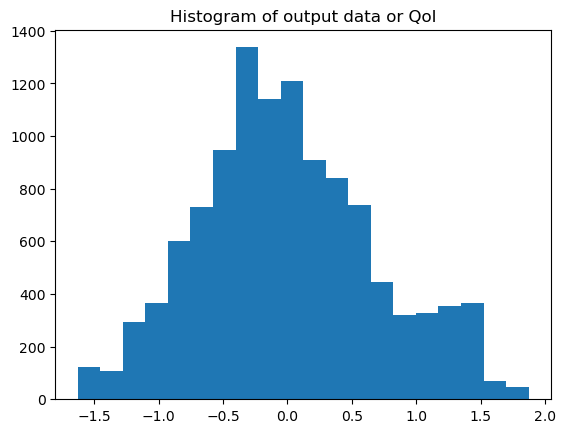

In [13]:
plt.hist(np.reshape(y, (-1,)), bins = 20);
plt.title("Histogram of output data or QoI")

Text(0.5, 1.0, 'Histogram of input data in log scale')

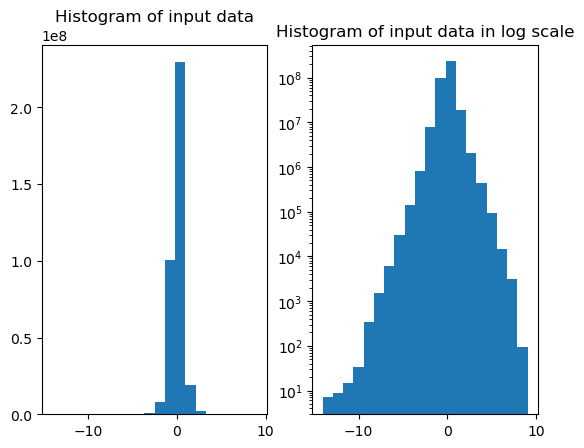

In [14]:
fig, ax = plt.subplots(1,2)
ax[0].hist(np.reshape(X_full, (-1,)), bins = 20);
ax[0].set_title("Histogram of input data")
ax[1].hist(np.reshape(X_full, (-1,)), bins = 20);
ax[1].set_yscale('log')
ax[1].set_title("Histogram of input data in log scale")

In [15]:
print(f"Preliminary analysis to justify using LRP bounded method for first layer of NN.")

frac_1 = np.count_nonzero((X_full<=1) & (X_full >= -1)) / (X_full.shape[0]*X_full.shape[1]) * 100
frac_2 = np.count_nonzero((X_full<=2) & (X_full >= -2)) / (X_full.shape[0]*X_full.shape[1]) * 100
frac_3 = np.count_nonzero((X_full<=3) & (X_full >= -3)) / (X_full.shape[0]*X_full.shape[1]) * 100

print(f"Mean of input data : {np.max(X_full):2.2f}")
print(f"Min of input data  : {np.min(X_full):2.2f}")
print(f"Max of input data  : {np.mean(X_full):2.2e}")
print(f"Std of input data  : {np.std(X_full):2.2f}")
print(f"Percentage of points within [-1,1] : {frac_1:2.2f}%")
print(f"Percentage of points within [-2,2] : {frac_2:2.2f}%")
print(f"Percentage of points within [-3,3] : {frac_3:2.2f}%")

Preliminary analysis to justify using LRP bounded method for first layer of NN.
Mean of input data : 9.02
Min of input data  : -14.06
Max of input data  : 3.03e-08
Std of input data  : 0.66
Percentage of points within [-1,1] : 89.34%
Percentage of points within [-2,2] : 98.45%
Percentage of points within [-3,3] : 99.66%


Text(0.5, 1.0, 'STD SST anomalies for each grid cell')

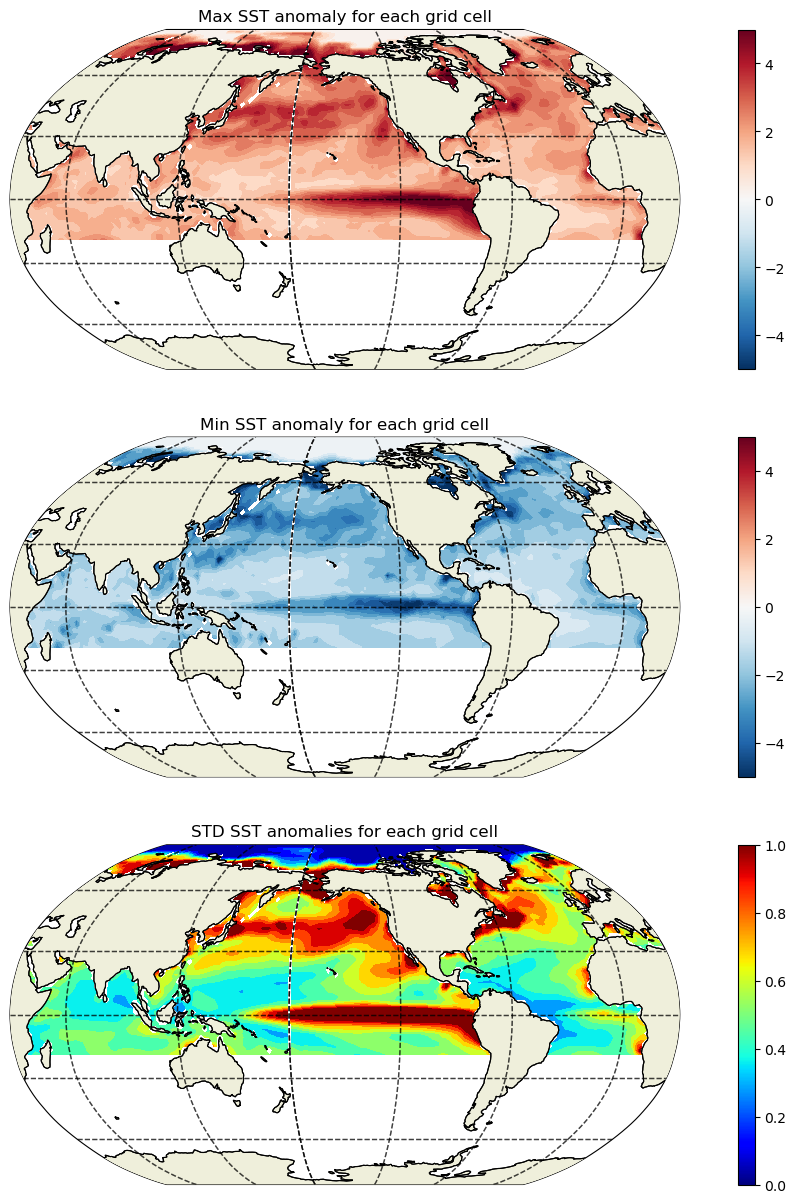

In [16]:
maxes = np.max(X_full, axis = 0)
mins  = np.min(X_full, axis = 0)
stds  = np.std(X_full, axis = 0)

maxes_global = np.zeros((ds['SST'].shape[1], ds['SST'].shape[2], ds['SST'].shape[3]), dtype = np.float64)
maxes_global[...] = np.nan
maxes_global[wetpoints[0],wetpoints[1],wetpoints[2]] = maxes

mins_global = np.zeros((ds['SST'].shape[1], ds['SST'].shape[2], ds['SST'].shape[3]), dtype = np.float64)
mins_global[...] = np.nan
mins_global[wetpoints[0],wetpoints[1],wetpoints[2]] = mins

stds_global = np.zeros((ds['SST'].shape[1], ds['SST'].shape[2], ds['SST'].shape[3]), dtype = np.float64)
stds_global[...] = np.nan
stds_global[wetpoints[0],wetpoints[1],wetpoints[2]] = stds

plt.figure(figsize=(15,15))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              maxes_global,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -5, cmax = 5, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,1,1]);
P[1].set_title("Max SST anomaly for each grid cell")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              mins_global,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -5, cmax = 5, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,1,2]);
P[1].set_title("Min SST anomaly for each grid cell")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              stds_global,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmin = 0, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,1,3]);
P[1].set_title("STD SST anomalies for each grid cell")

Text(0.5, 1.0, "Histogram of std of each grid-point's time series")

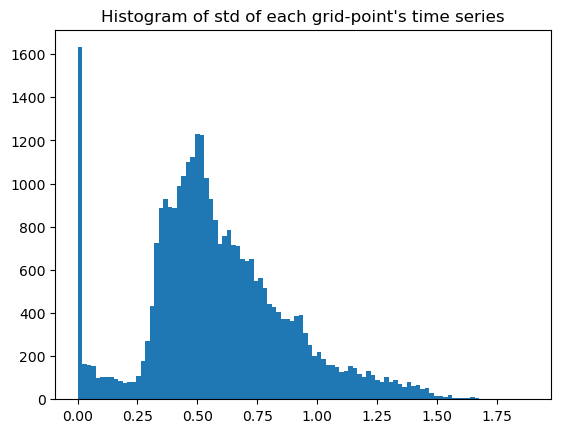

In [17]:
plt.hist(np.reshape(stds, (-1,)), bins = 100);
plt.title("Histogram of std of each grid-point's time series")

Text(0.5, 1.0, 'SST anomaly 2022_12_31')

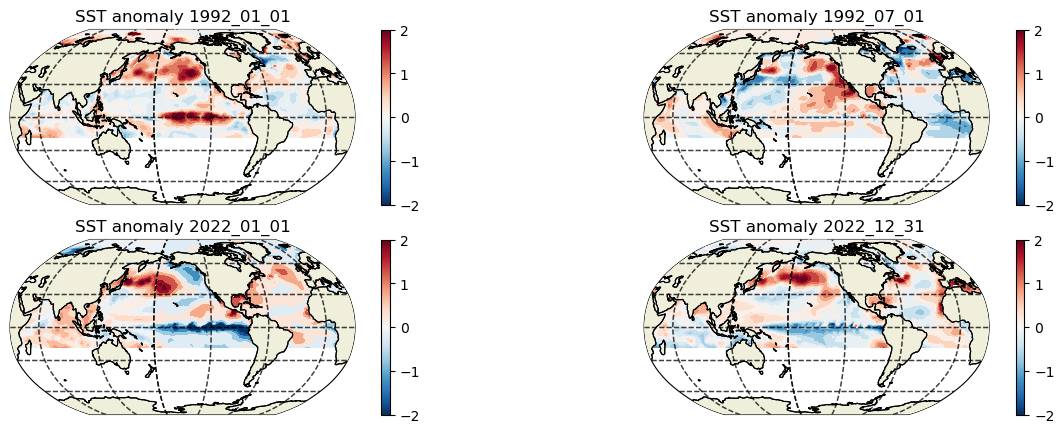

In [18]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[0],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,1]);
P[1].set_title("SST anomaly 1992_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[182],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,2]);
P[1].set_title("SST anomaly 1992_07_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[-365],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,3]);
P[1].set_title("SST anomaly 2022_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[-1],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,4]);
P[1].set_title("SST anomaly 2022_12_31")

## Correlation maps

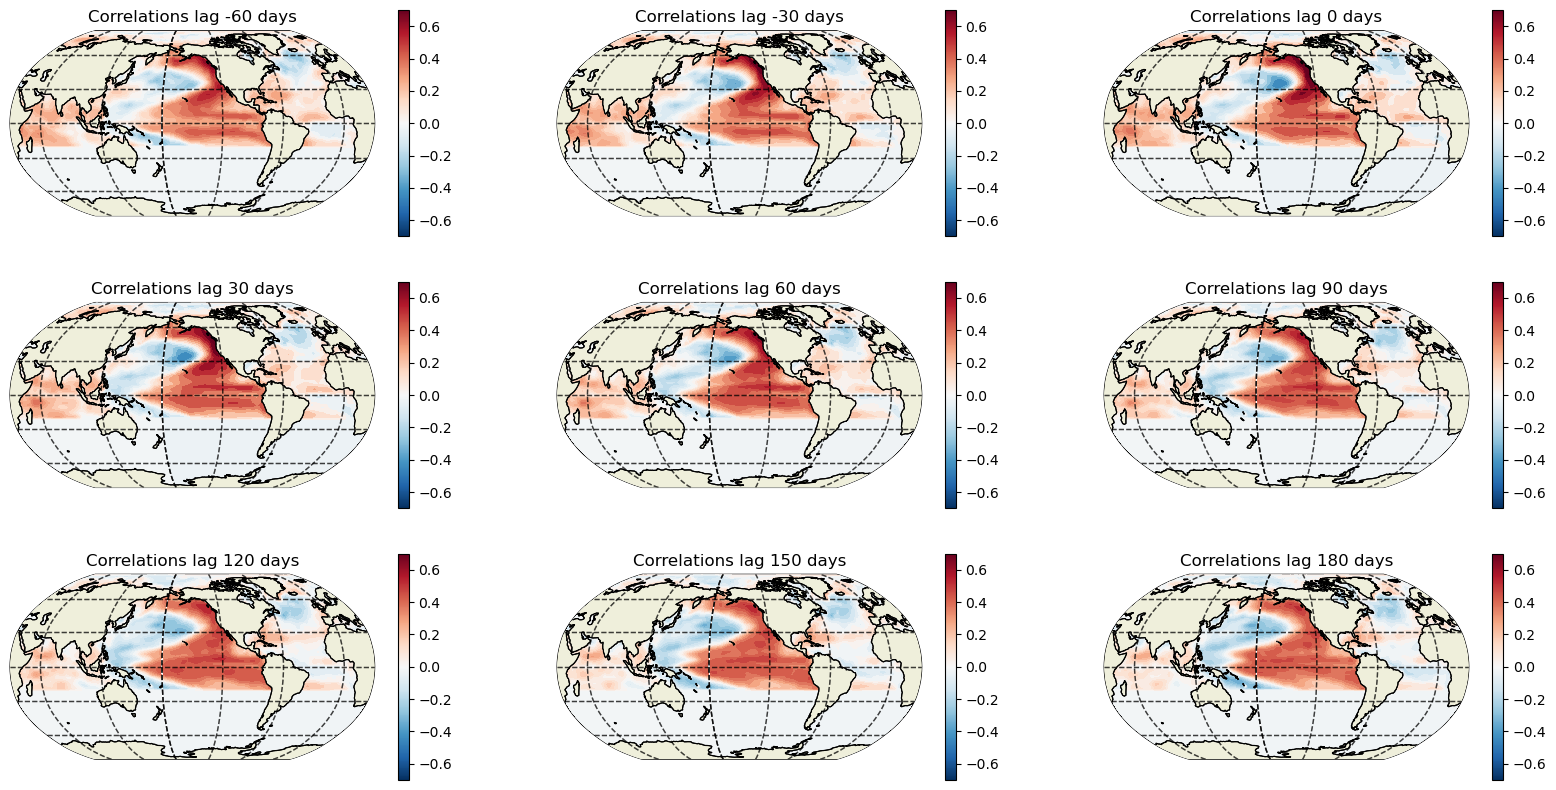

In [19]:
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lagSteps in lagStepsList:
    
    corr = np.zeros((13, 90, 90))
    
    if lagSteps > 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[:-lagSteps],y[lagSteps:]))
    elif lagSteps == 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X,y))
    else:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[-lagSteps:],y[:lagSteps]))

    P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', 
                                  cmin = -0.7, cmax = 0.7, user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [3,3,subplot_idx]);
    P[1].set_title(f"Correlations lag {lagSteps} days")
    
    subplot_idx += 1

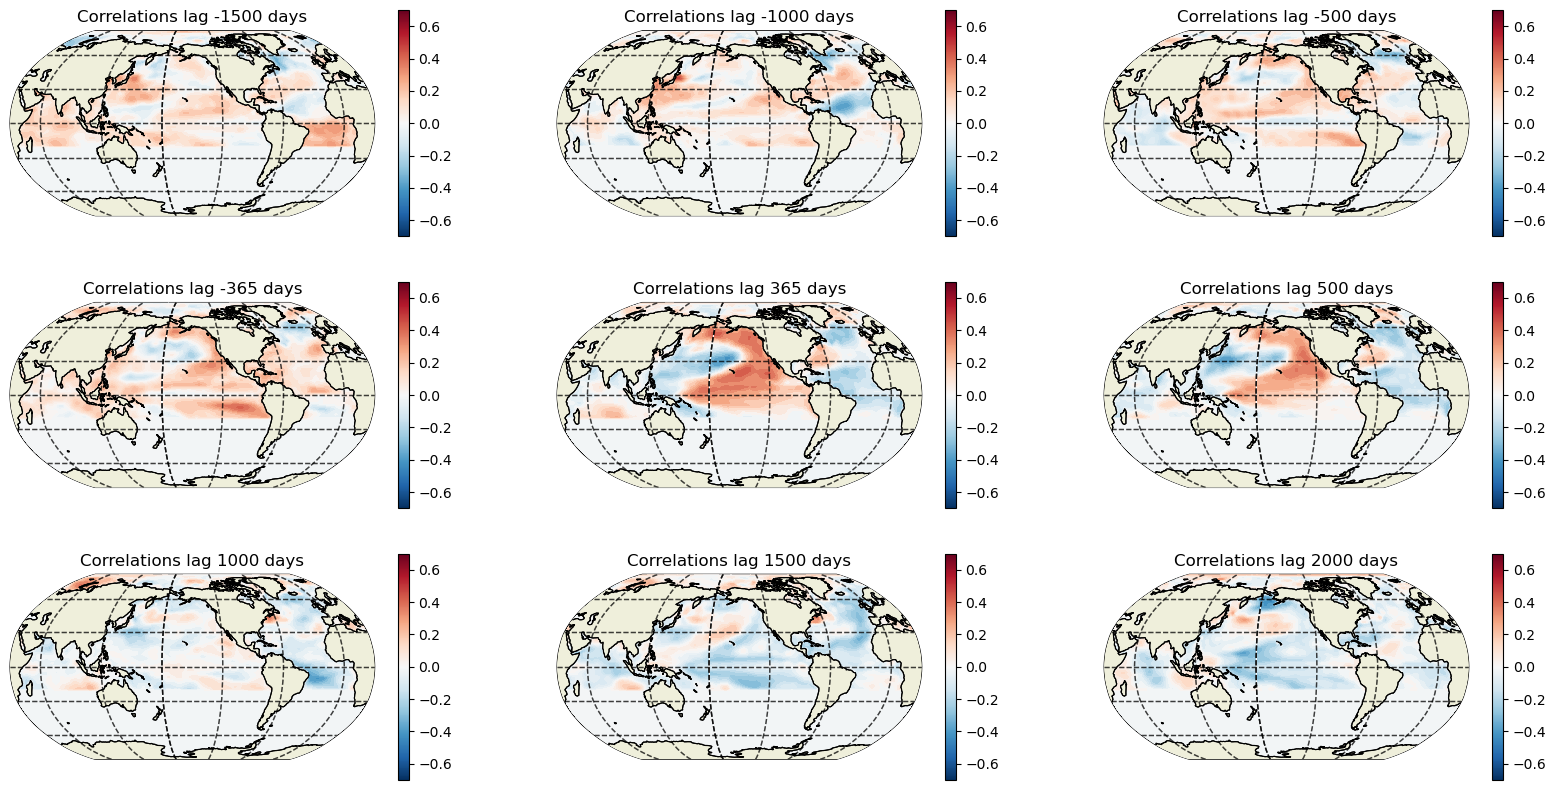

In [20]:
lagStepsList = [-1500,-1000,-500,-365,365,500,1000,1500,2000]

subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lagSteps in lagStepsList:
    
    corr = np.zeros((13, 90, 90))
    
    if lagSteps > 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[:-lagSteps],y[lagSteps:]))
    elif lagSteps == 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X,y))
    else:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[-lagSteps:],y[:lagSteps]))

    P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', 
                                  cmin = -0.7, cmax = 0.7, user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [3,3,subplot_idx]);
    P[1].set_title(f"Correlations lag {lagSteps} days")
    
    subplot_idx += 1